In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (classification_report, confusion_matrix,
                             roc_auc_score, roc_curve, ConfusionMatrixDisplay)
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import warnings
warnings.filterwarnings('ignore')

# Load data
df = pd.read_csv('../data/processed/loan_default_cleaned.csv')

# ---- FEATURE ENGINEERING ----
df = df.drop('LoanID', axis=1)

# Encode binary columns
binary_cols = ['HasMortgage', 'HasDependents', 'HasCoSigner']
for col in binary_cols:
    df[col] = (df[col] == 'Yes').astype(int)

# One hot encode categoricals
df = pd.get_dummies(df, columns=['Education', 'EmploymentType',
                                  'MaritalStatus', 'LoanPurpose'],
                    drop_first=True)

print("Features shape:", df.shape)
print("Default rate:", df['Default'].mean())

# ---- TRAIN TEST SPLIT ----
X = df.drop('Default', axis=1)
y = df['Default']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y)

print(f"\nTrain size: {X_train.shape[0]}")
print(f"Test size: {X_test.shape[0]}")

# ---- HANDLE IMBALANCE WITH SMOTE ----
smote = SMOTE(random_state=42)
X_train_sm, y_train_sm = smote.fit_resample(X_train, y_train)
print(f"\nAfter SMOTE — Train size: {X_train_sm.shape[0]}")
print(f"Class distribution: {y_train_sm.value_counts().to_dict()}")

# ---- SCALE FEATURES ----
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_sm)
X_test_scaled = scaler.transform(X_test)

# ---- TRAIN THREE MODELS ----
models = {
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(random_state=42, eval_metric='logloss')
}

results = {}
for name, model in models.items():
    model.fit(X_train_scaled, y_train_sm)
    y_pred = model.predict(X_test_scaled)
    y_prob = model.predict_proba(X_test_scaled)[:,1]
    auc = roc_auc_score(y_test, y_prob)
    results[name] = {
        'model': model,
        'y_pred': y_pred,
        'y_prob': y_prob,
        'auc': auc
    }
    print(f"\n{name} — AUC: {auc:.4f}")
    print(classification_report(y_test, y_pred))

Features shape: (255347, 25)
Default rate: 0.11612824901017048

Train size: 204277
Test size: 51070

After SMOTE — Train size: 361110
Class distribution: {0: 180555, 1: 180555}

Logistic Regression — AUC: 0.6677
              precision    recall  f1-score   support

           0       0.91      0.88      0.89     45139
           1       0.25      0.30      0.27      5931

    accuracy                           0.81     51070
   macro avg       0.58      0.59      0.58     51070
weighted avg       0.83      0.81      0.82     51070


Random Forest — AUC: 0.7151
              precision    recall  f1-score   support

           0       0.89      0.96      0.93     45139
           1       0.31      0.13      0.19      5931

    accuracy                           0.87     51070
   macro avg       0.60      0.55      0.56     51070
weighted avg       0.83      0.87      0.84     51070


XGBoost — AUC: 0.7367
              precision    recall  f1-score   support

           0       0.89    

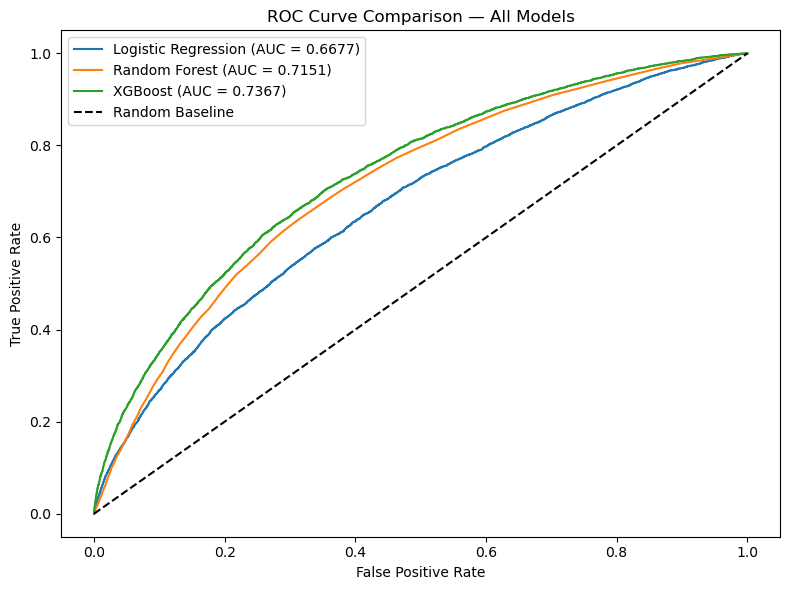

Threshold Tuning — XGBoost:
Threshold    Precision    Recall       F1          
------------------------------------------------
0.1          0.191        0.759        0.305       
0.15         0.228        0.627        0.335       
0.2          0.258        0.510        0.343       
0.25         0.292        0.411        0.342       
0.3          0.326        0.327        0.327       
0.35         0.361        0.259        0.302       
0.4          0.400        0.201        0.267       
0.5          0.471        0.115        0.185       


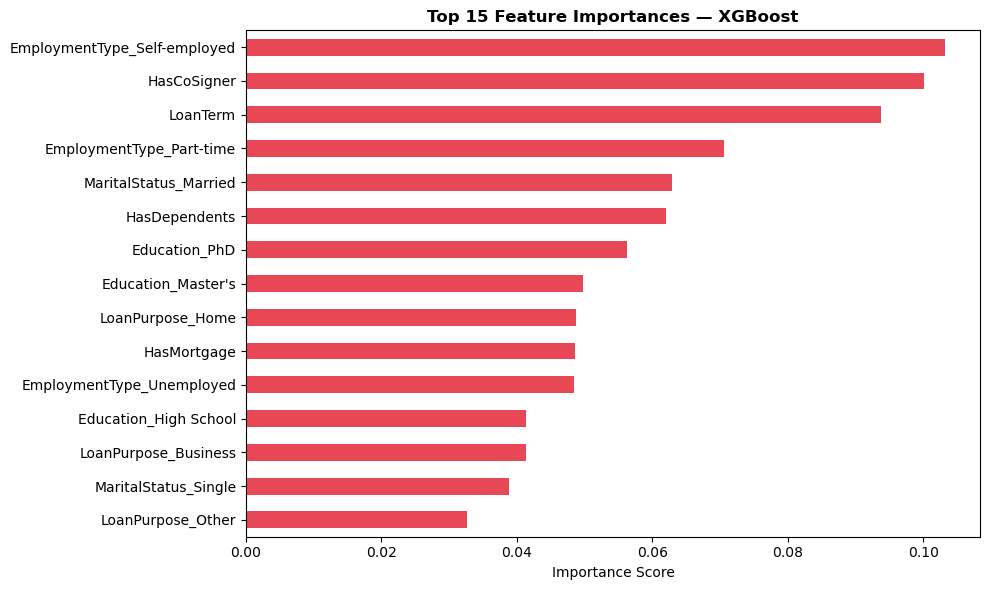


Top 15 features driving default:
EmploymentType_Self-employed    0.103186
HasCoSigner                     0.100106
LoanTerm                        0.093755
EmploymentType_Part-time        0.070489
MaritalStatus_Married           0.062950
HasDependents                   0.062071
Education_PhD                   0.056268
Education_Master's              0.049697
LoanPurpose_Home                0.048704
HasMortgage                     0.048584
EmploymentType_Unemployed       0.048381
Education_High School           0.041269
LoanPurpose_Business            0.041263
MaritalStatus_Single            0.038791
LoanPurpose_Other               0.032644
dtype: float32

Risk Tier Distribution:
risk_tier
Medium       19250
Low          15528
High         10343
Very High     5949
Name: count, dtype: int64

Actual Default Rate by Risk Tier:
risk_tier
Low          0.036
Medium       0.086
High         0.172
Very High    0.326
Name: actual_default, dtype: float64

Risk scored data saved.


In [2]:
# ---- ROC CURVES ----
plt.figure(figsize=(8, 6))
for name, res in results.items():
    fpr, tpr, _ = roc_curve(y_test, res['y_prob'])
    plt.plot(fpr, tpr, label=f"{name} (AUC = {res['auc']:.4f})")
plt.plot([0,1],[0,1],'k--', label='Random Baseline')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve Comparison — All Models')
plt.legend()
plt.tight_layout()
plt.savefig('../visuals/03_roc_curves.png', dpi=150, bbox_inches='tight')
plt.show()

# ---- THRESHOLD TUNING ON XGBOOST ----
from sklearn.metrics import precision_recall_curve, f1_score

xgb_probs = results['XGBoost']['y_prob']

# Test different thresholds
thresholds = [0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.5]
print("Threshold Tuning — XGBoost:")
print(f"{'Threshold':<12} {'Precision':<12} {'Recall':<12} {'F1':<12}")
print("-" * 48)
for t in thresholds:
    y_pred_t = (xgb_probs >= t).astype(int)
    from sklearn.metrics import precision_score, recall_score
    p = precision_score(y_test, y_pred_t, zero_division=0)
    r = recall_score(y_test, y_pred_t)
    f = f1_score(y_test, y_pred_t)
    print(f"{t:<12} {p:<12.3f} {r:<12.3f} {f:<12.3f}")

# ---- FEATURE IMPORTANCE — XGBoost ----
feature_names = X.columns.tolist()
xgb_model = results['XGBoost']['model']
importances = pd.Series(xgb_model.feature_importances_, index=feature_names)
top_features = importances.sort_values(ascending=False).head(15)

plt.figure(figsize=(10, 6))
top_features.plot(kind='barh', color='#E84855')
plt.gca().invert_yaxis()
plt.title('Top 15 Feature Importances — XGBoost', fontweight='bold')
plt.xlabel('Importance Score')
plt.tight_layout()
plt.savefig('../visuals/04_feature_importance.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nTop 15 features driving default:")
print(top_features)

# ---- RISK SCORING ----
# Assign risk tiers based on predicted probability
df_test = X_test.copy()
df_test['actual_default'] = y_test.values
df_test['default_probability'] = xgb_probs

df_test['risk_tier'] = pd.cut(xgb_probs,
                               bins=[0, 0.05, 0.15, 0.30, 1.0],
                               labels=['Low', 'Medium', 'High', 'Very High'])

print("\nRisk Tier Distribution:")
print(df_test['risk_tier'].value_counts())
print("\nActual Default Rate by Risk Tier:")
print(df_test.groupby('risk_tier')['actual_default'].mean().round(3))

# Save risk scored test set
df_test.to_csv('../data/processed/risk_scored.csv', index=False)
print("\nRisk scored data saved.")

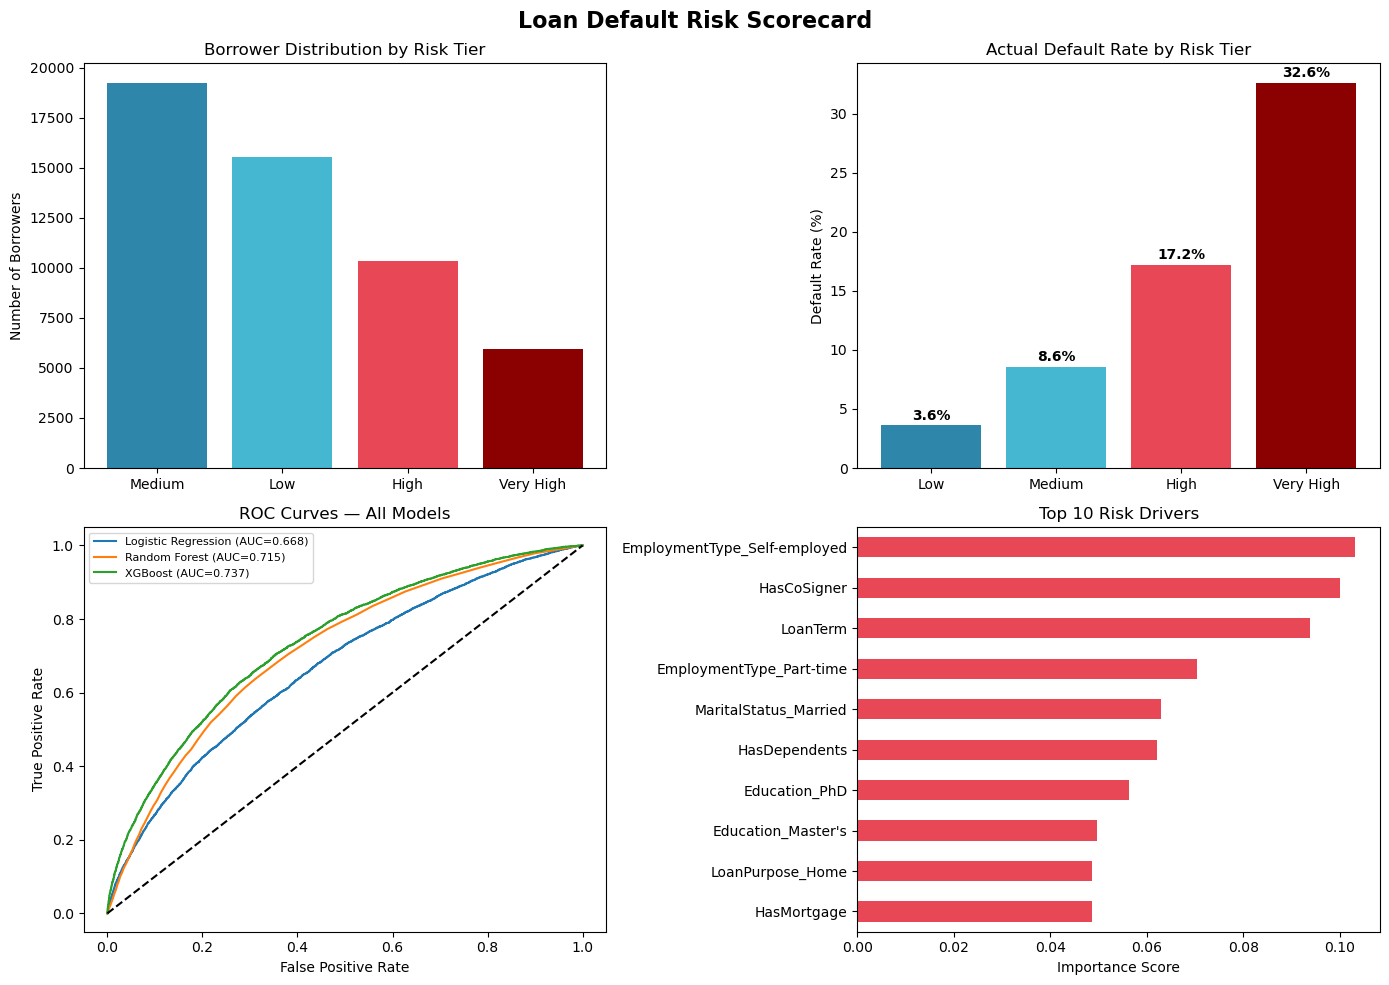

Model Comparison Summary:
              Model    AUC  Accuracy  Default Precision  Default Recall  Default F1
Logistic Regression 0.6677    0.8136             0.2497          0.3020      0.2734
      Random Forest 0.7151    0.8655             0.3127          0.1322      0.1858
            XGBoost 0.7367    0.8822             0.4714          0.1152      0.1851

Optimal Threshold (XGBoost): 0.15
Recall at 0.15 threshold: 0.627
Risk Tier Separation: 3.6% → 32.6% (9x)


In [3]:
# ---- RISK SCORECARD VISUALIZATION ----
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Loan Default Risk Scorecard', fontsize=16, fontweight='bold')

# Plot 1: Risk Tier Distribution
tier_counts = df_test['risk_tier'].value_counts()
colors = ['#2E86AB', '#45B7D1', '#E84855', '#8B0000']
axes[0,0].bar(tier_counts.index, tier_counts.values, color=colors)
axes[0,0].set_title('Borrower Distribution by Risk Tier')
axes[0,0].set_ylabel('Number of Borrowers')

# Plot 2: Actual Default Rate by Risk Tier
tier_default = df_test.groupby('risk_tier')['actual_default'].mean()
axes[0,1].bar(tier_default.index, tier_default.values * 100, color=colors)
axes[0,1].set_title('Actual Default Rate by Risk Tier')
axes[0,1].set_ylabel('Default Rate (%)')
for i, v in enumerate(tier_default.values):
    axes[0,1].text(i, v*100 + 0.5, f'{v*100:.1f}%', ha='center', fontweight='bold')

# Plot 3: ROC Curve (replot)
for name, res in results.items():
    fpr, tpr, _ = roc_curve(y_test, res['y_prob'])
    axes[1,0].plot(fpr, tpr, label=f"{name} (AUC={res['auc']:.3f})")
axes[1,0].plot([0,1],[0,1],'k--')
axes[1,0].set_title('ROC Curves — All Models')
axes[1,0].set_xlabel('False Positive Rate')
axes[1,0].set_ylabel('True Positive Rate')
axes[1,0].legend(fontsize=8)

# Plot 4: Feature Importance
top_features.head(10).plot(kind='barh', ax=axes[1,1], color='#E84855')
axes[1,1].invert_yaxis()
axes[1,1].set_title('Top 10 Risk Drivers')
axes[1,1].set_xlabel('Importance Score')

plt.tight_layout()
plt.savefig('../visuals/05_risk_scorecard.png', dpi=150, bbox_inches='tight')
plt.show()

# ---- MODEL SUMMARY ----
summary = []
for name, res in results.items():
    report = classification_report(y_test, res['y_pred'], output_dict=True)
    summary.append({
        'Model': name,
        'AUC': round(res['auc'], 4),
        'Accuracy': round(report['accuracy'], 4),
        'Default Precision': round(report['1']['precision'], 4),
        'Default Recall': round(report['1']['recall'], 4),
        'Default F1': round(report['1']['f1-score'], 4)
    })

summary_df = pd.DataFrame(summary)
print("Model Comparison Summary:")
print(summary_df.to_string(index=False))
print("\nOptimal Threshold (XGBoost): 0.15")
print("Recall at 0.15 threshold: 0.627")
print("Risk Tier Separation: 3.6% → 32.6% (9x)")